In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

data = xr.open_dataset("test_data/garbe_2020_antarctica.nc")
data = data.coarsen(x=2, y=2, time=2, boundary="trim").reduce(np.mean)

In [2]:
# with this, you don't need to restart the notebook after making changes in the toad package.
%load_ext autoreload
%autoreload 2
from toad import TOAD

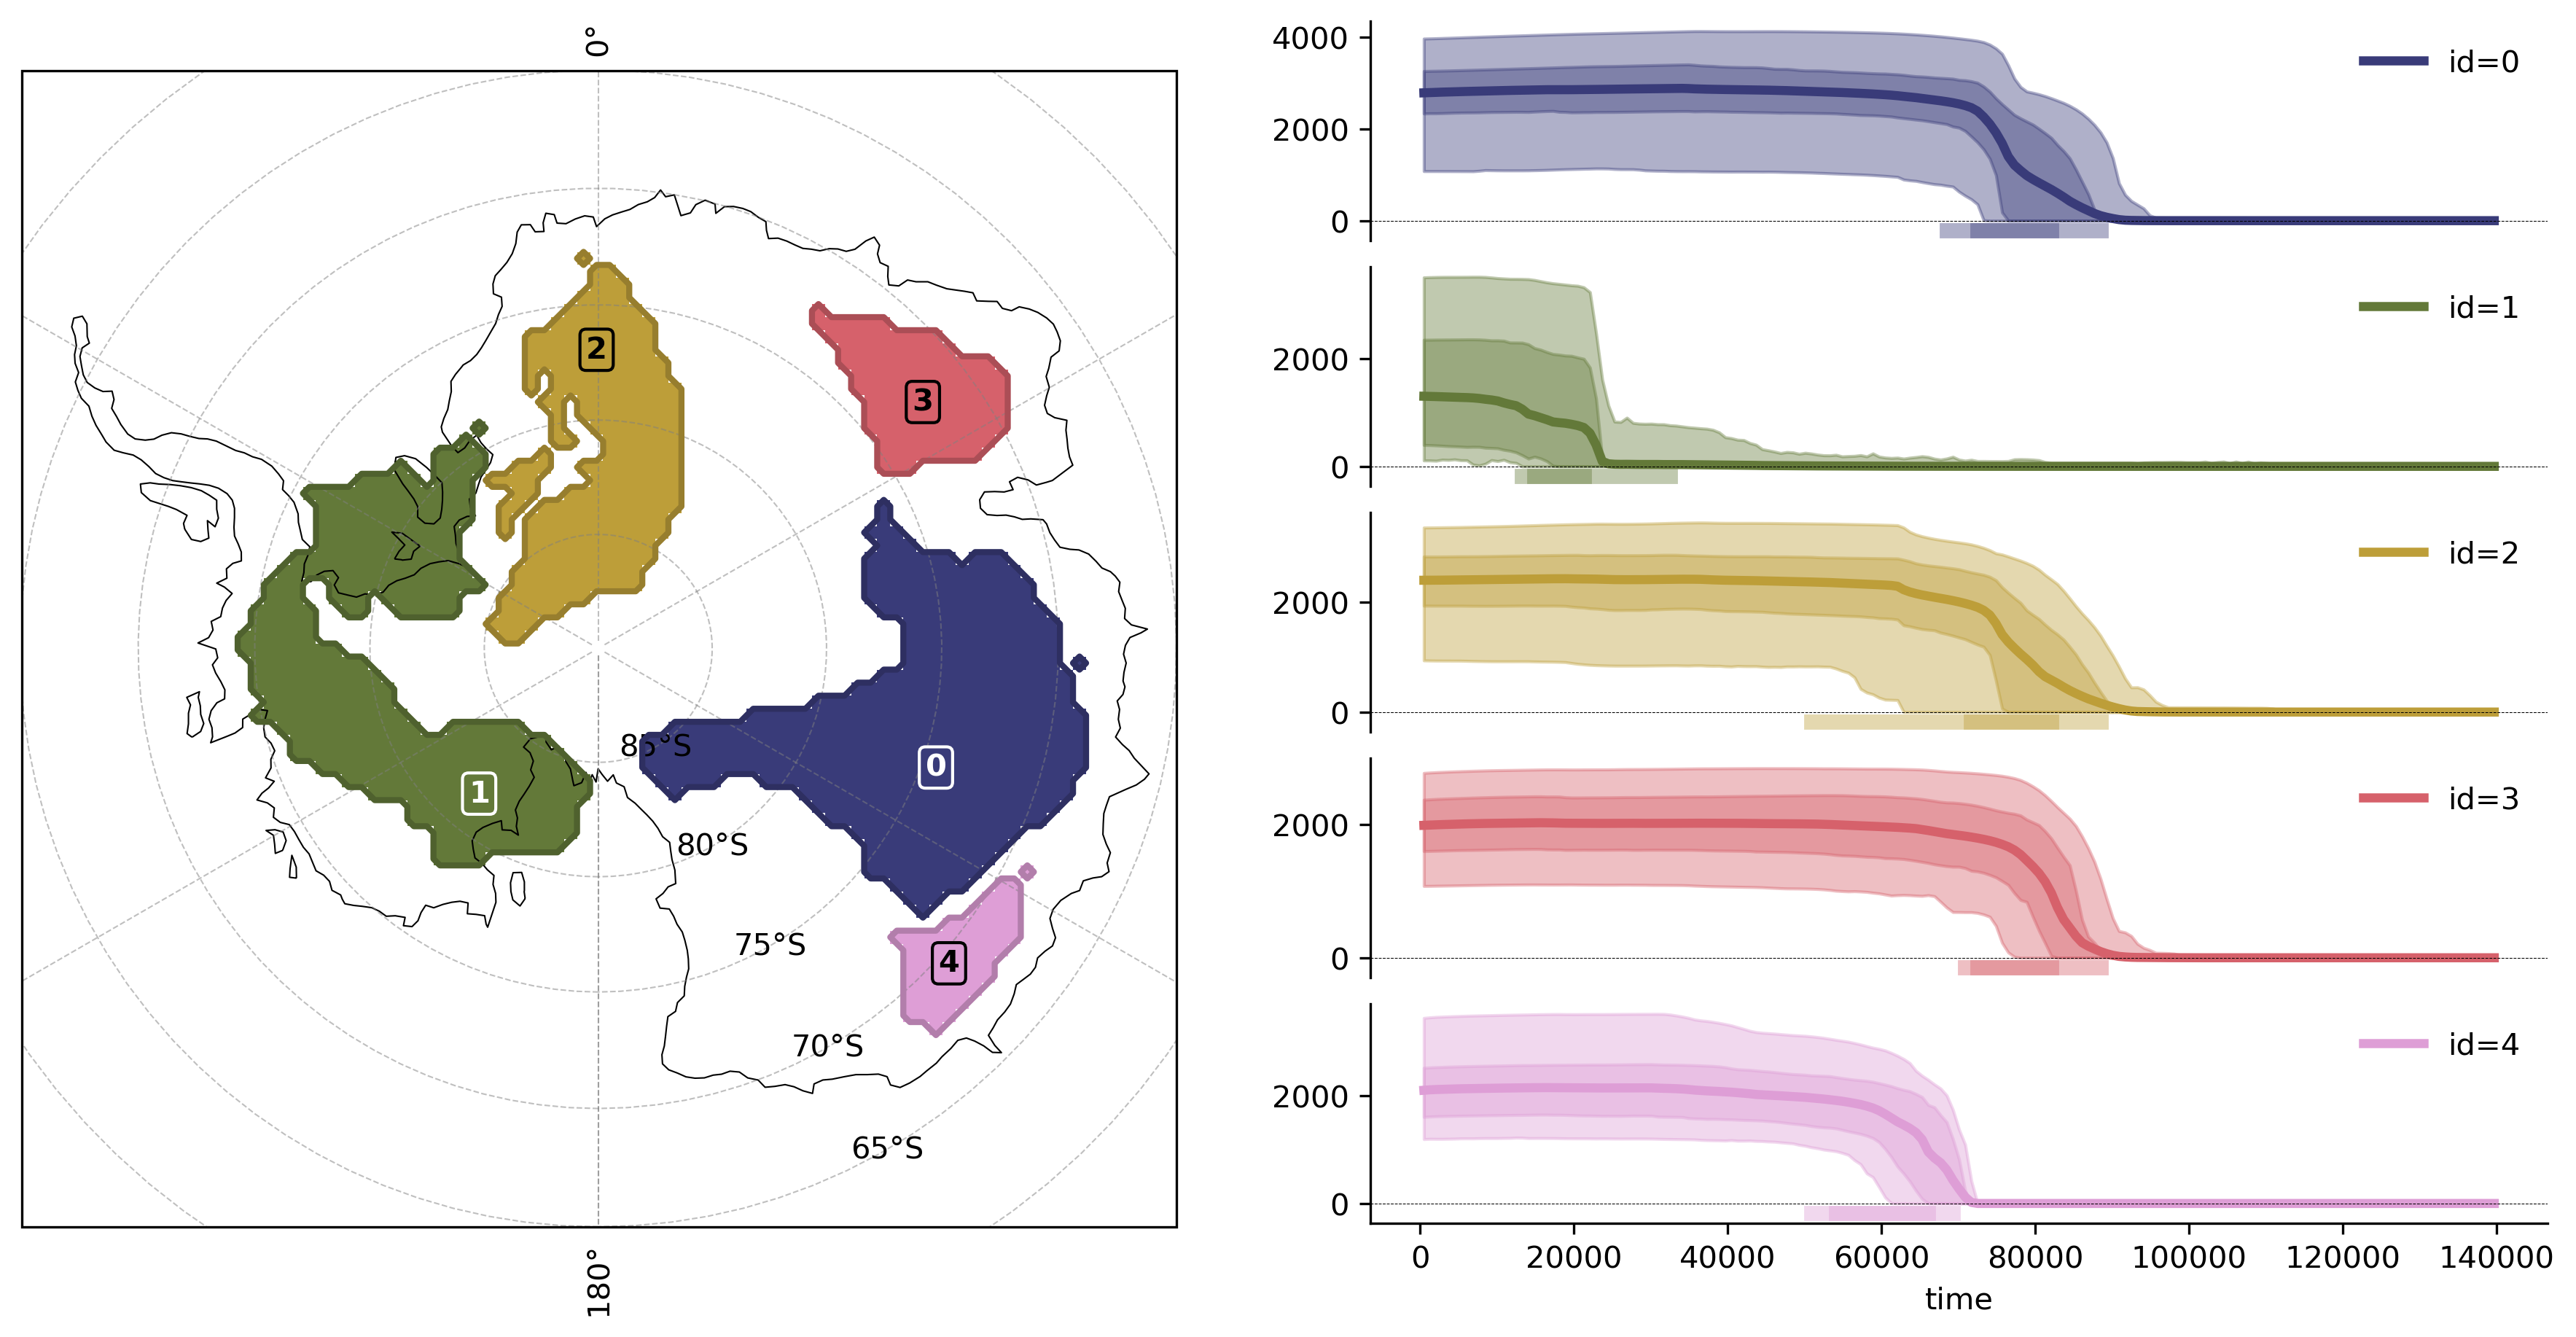

In [3]:
# from toad.shifts_detection.methods import ASDETECT
from sklearn.cluster import HDBSCAN  # type: ignore

td = TOAD(data)
# td.compute_shifts("thk", method=ASDETECT()) # already computed

td.compute_clusters(
    var="thk",
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x) > 0.9,
)

td.plotter().cluster_overview("thk", cluster_ids=range(5), projection="south_pole");

Compute cluster_abruptness for first 5 clusters. This score gives a number between 0 and 1, where 0 means that the mean of the timeseries is a perfect linear slope, while 1 means that the mean of the timeseries is a perfect heavyside function.


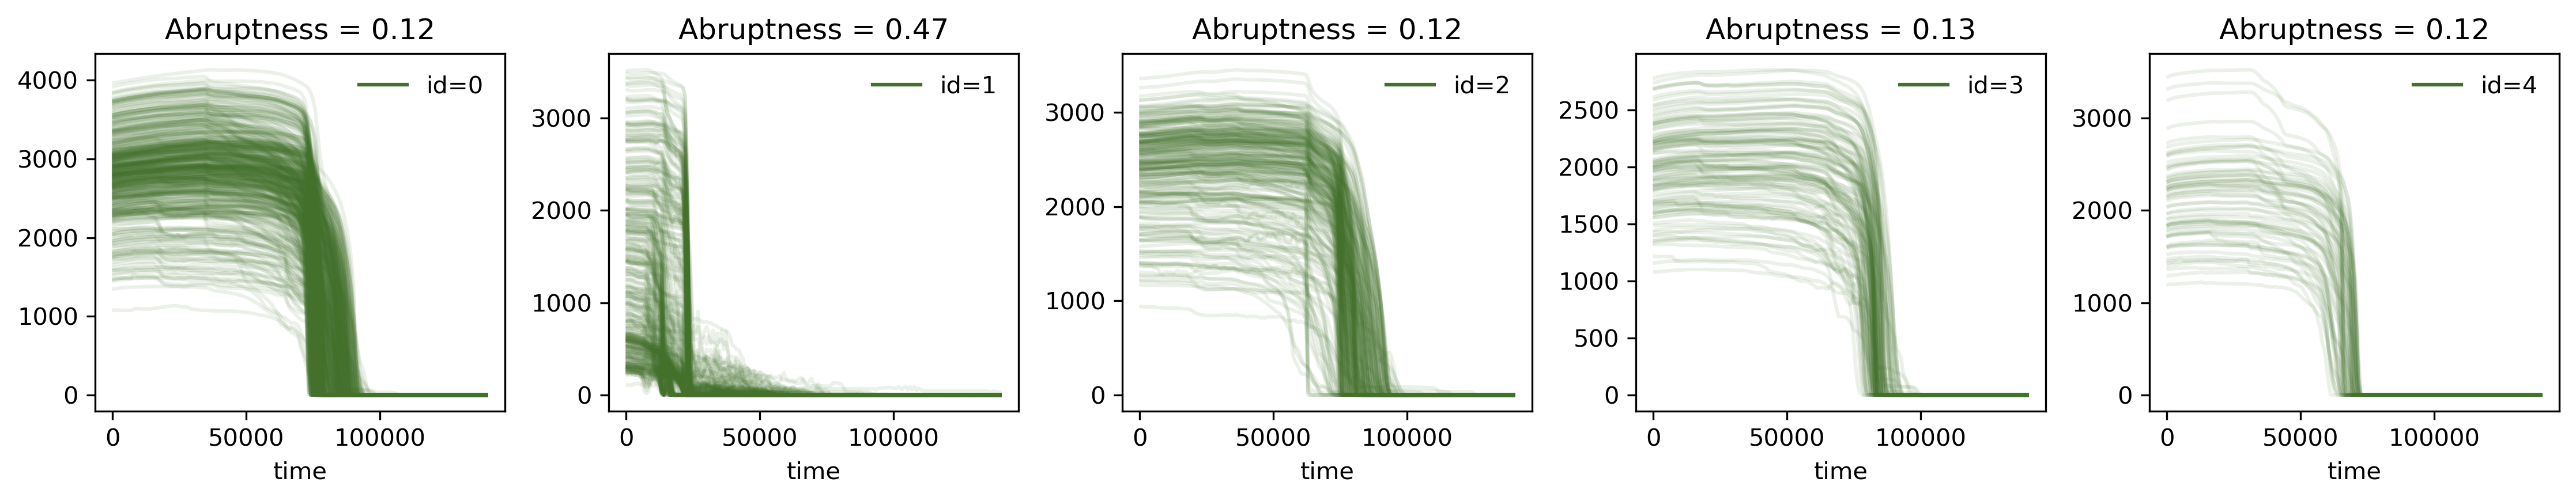

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    td.plotter().cluster_timeseries("thk", cluster_ids=[i], ax=axs[i])
    axs[i].set_ylabel("")

    # plot cluster_abruptness as title
    score = td.cluster_stats("thk").general.score_heaviside(cluster_id=i)
    axs[i].set_title(f"Abruptness = {score:.2f}")

plt.tight_layout()

Compute cluster spatial autocorrelation for the first 5 clusters. This score gives the average pairwise similarity (Rsquared) of the timeseries in each cluster. A value of 1 means that the timeseries in the cluster are perfectly correlated with each other, a value of 0 means no correlation. You can interpret the value like this: "On average x % of the variance of a random timeseries in the cluster can be explained by all other timeseries in the cluster".


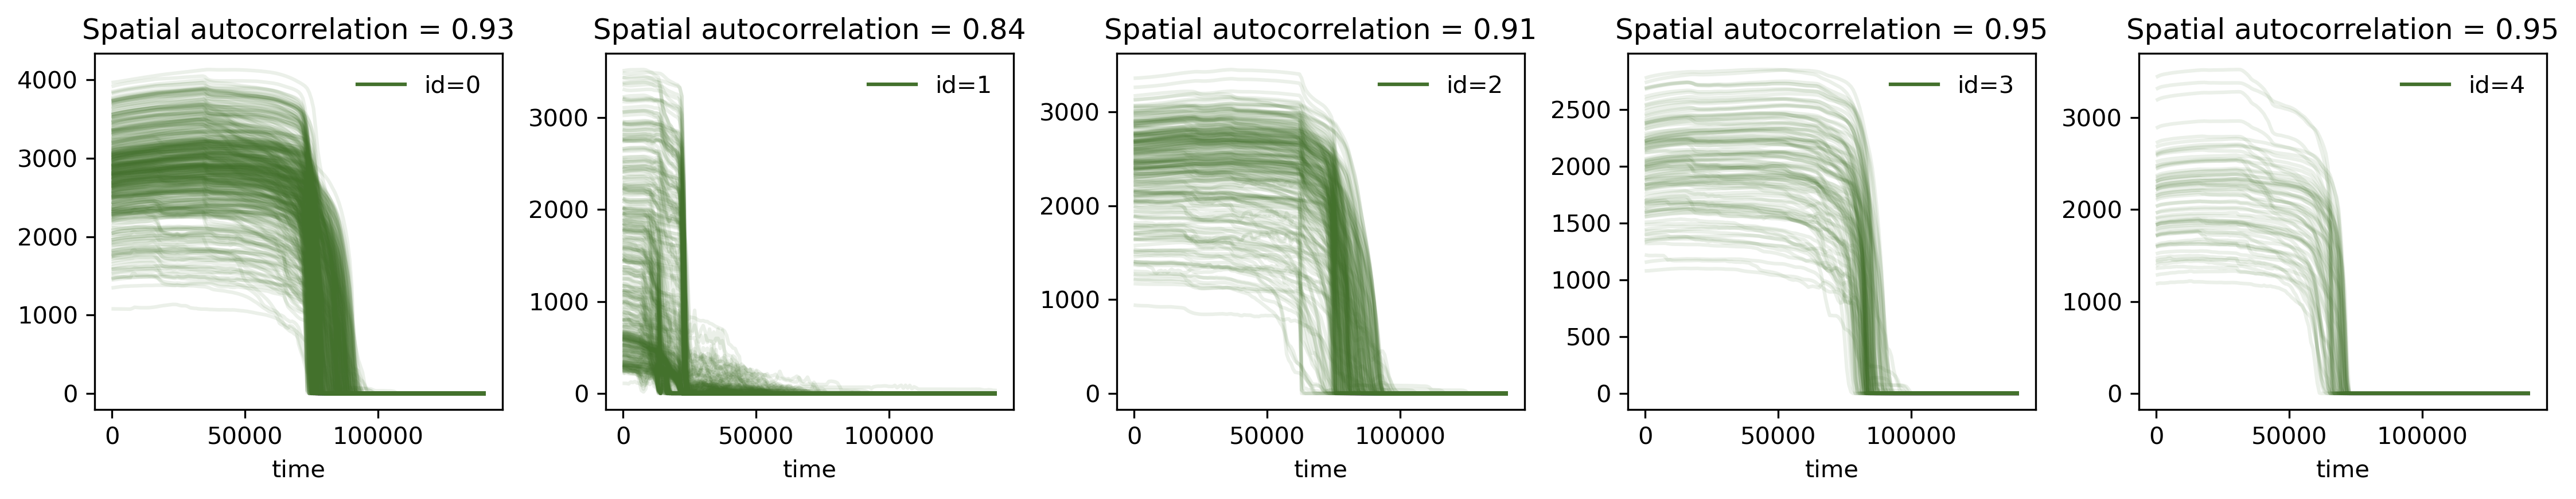

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    td.plotter().cluster_timeseries("thk", cluster_ids=[i], ax=axs[i])
    axs[i].set_ylabel("")

    # plot cluster_abruptness as title
    score = td.cluster_stats("thk").general.score_spatial_autocorrelation(cluster_id=i)
    axs[i].set_title(f"Spatial autocorrelation = {score:.2f}")

plt.tight_layout()

You can learn from this example that the dynamics in cluster 1 and 2 are less strongly connected internally and hence are "weaker" clusters. This also makes sense looking at the plotted timeseries.


Next metric: cluster consistency for the first 5 clusters. The measure shows if there are any inconsistencies in the clusters. Some clusters may have a strong average spatial autocorrelation but not all timeseries are strongly connected to each other. Clusters may have certain subgroups that are stronger connected internally but less to each other. Such inconsistencies with strong subgroups are reflected in the measure as low values. If all timeseries are consistenly similar to each other, then the cluster consistency value is higher.


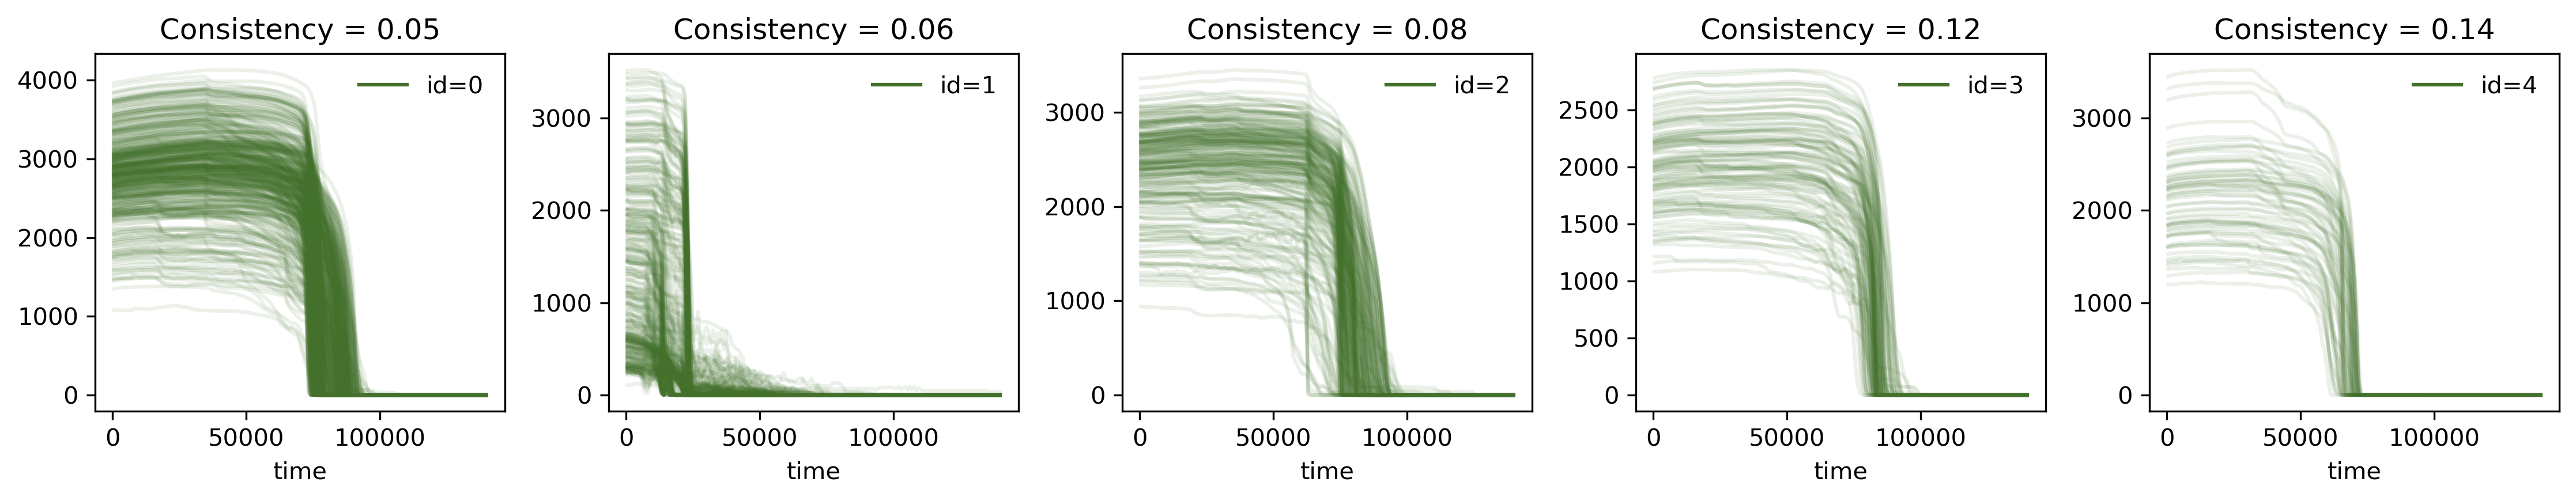

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    td.plotter().cluster_timeseries("thk", cluster_ids=[i], ax=axs[i])
    axs[i].set_ylabel("")

    # plot cluster_abruptness as title
    score = td.cluster_stats("thk").general.score_consistency(cluster_id=i)
    axs[i].set_title(f"Consistency = {score:.2f}")

plt.tight_layout()

We notice that the first three clusters are less consistent and hence have more strong subgroups/potential subclusters. This is also visible in the time series plot. Clusters 3 and 4 on the other hand show higher consistency.


Last we will try the nonlinearity measure as alternative to the cluster abruptness. I think cluster abruptness is more clearly defined but let's see if they reveal the same insights. Cluster nonlinearity is measured as how poor the linear fit of the spatially aggregated time series of the cluster is. Higher values (RMSE) mean hence higher nonlinearity. In the function there is the option to compute these nonlinearity values compared to the spatially aggregated time series of the unclustered gridcells (RMSE cluster/RMSE unclustered). This can be useful to rule out high nonlinearities that may have been missed by all clusters and makes the measure more relative.


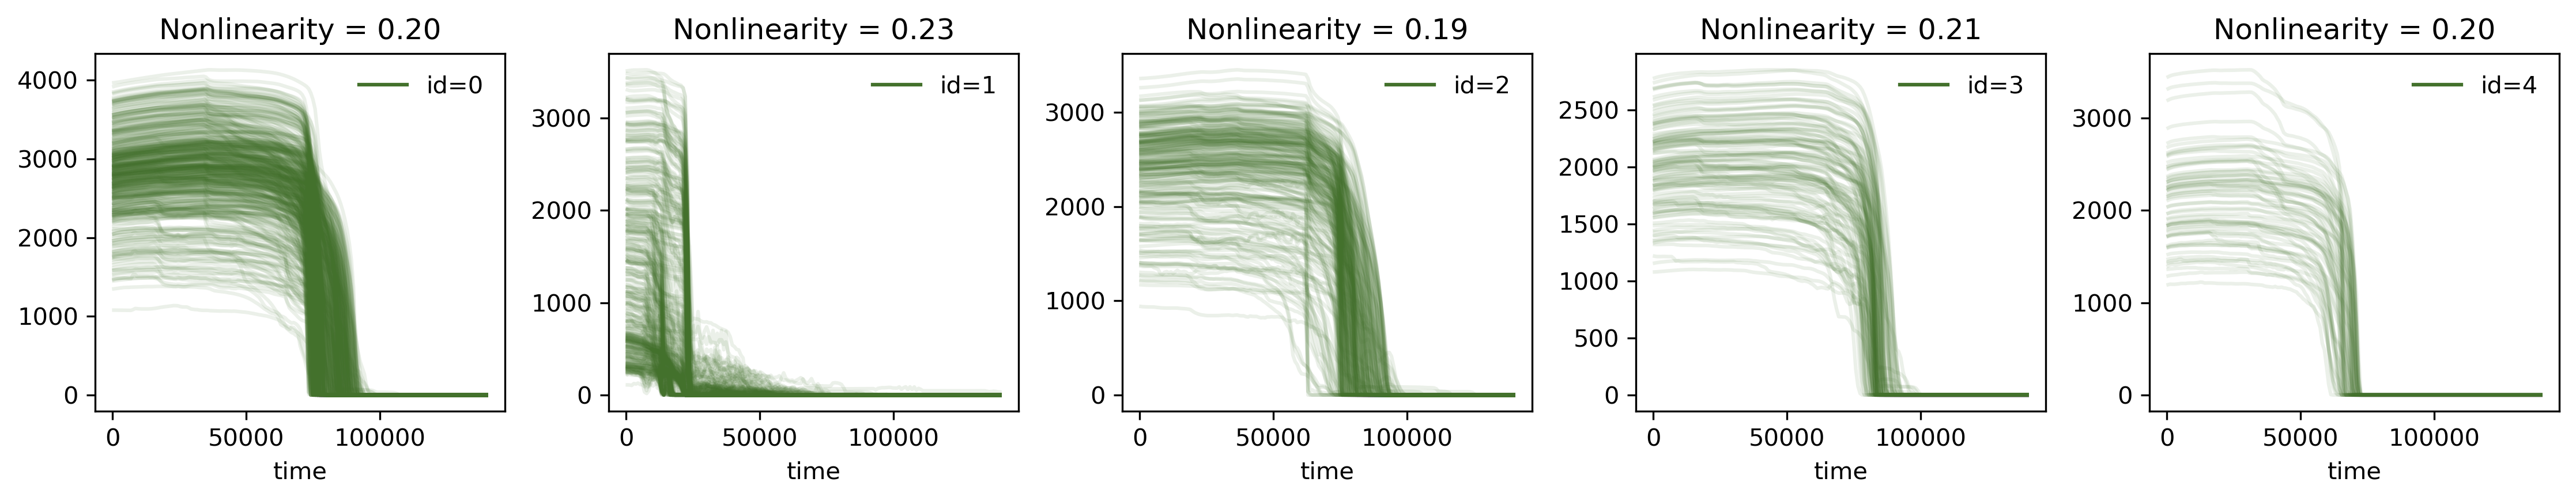

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    td.plotter().cluster_timeseries("thk", cluster_ids=[i], ax=axs[i])
    axs[i].set_ylabel("")

    # plot cluster_abruptness as title
    score = td.cluster_stats("thk").general.score_nonlinearity(cluster_id=i)
    axs[i].set_title(f"Nonlinearity = {score:.2f}")

plt.tight_layout()